### Semi-autonomous Teleoperation Demo : Place task in `Office` scene

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.4]


In [2]:
xml_path = '../../../asset/visualize_figure_bookshelf_genre.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([-1.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-5,0.80,0])

shelf_pos = np.array([0.8,0.0,0.75])
shelf_2nd_pos = shelf_pos + np.array([0.,0.,0.25])
env.model.body('shelf_row1').pos = shelf_pos
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))

obj_box_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_box"))]
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]
obj_book_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("book"))]

# Place objects
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)
n_wine_obj = 2
env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[-0.2, 0.2], z_range=[1.35,1.36], min_dist=0.05, COLORS=False, VERBOSE=True)

# Book1 is target_object
env.model.joint(env.model.body('book2').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.225, 0.02])
env.model.joint(env.model.body('book3').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.16, 0.02])
env.model.joint(env.model.body('book4').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.11, 0.02])
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.22, 0.02])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.16, 0.02])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.12, 0.02])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.07, 0.02])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window
obj_wine_01: [0.84 0.1  1.36]
obj_wine_02: [ 0.81 -0.15  1.36]


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()

# init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=500):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[-1.01 -0.13  1.16]
Pressed ESC
Quitting.


2025-06-14 13:50:48.959 python[69941:1892746] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [4]:
env.get_p_body('book4')

array([0.8 , 0.11, 1.01])

In [5]:
env.get_p_body('book1')

array([ 0.2 , -0.4 ,  0.79])

### Get all `the Physically Plausible` positions

In [6]:
def uniform_sample_position(x_range, y_range, z_range, n_sample):
    x_values = np.linspace(x_range[0], x_range[1], 10)
    y_values = np.linspace(y_range[0], y_range[1], 10)
    z_values_floor1 = np.linspace(z_range[0], 1.2, 5)
    z_values_floor2 = np.linspace(1.2, z_range[1], 5)
    
    positions = []
    for x in x_values:
        for y in y_values:
            for z1 in z_values_floor1:  # 1st floor
                positions.append((x, y, z1))
            for z2 in z_values_floor2:  # 2nd floor
                positions.append((x, y, z2))
    
    return np.array(positions)

x_range = np.array([0.4, 1.25])
y_range = np.array([-0.55, 0.55])
# 0.8m: 1st floor, 0.8m: 2nd floor
z_range = np.array([0.8, 1.5])

n_sample = 15
uniform_positions = uniform_sample_position(x_range, y_range, z_range, n_sample)
uniform_positions.shape

(1000, 3)

In [7]:
# Wine / Shelves
def get_geom_region_type1(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object based on the lower corner
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z - size_d],
        [center_x - size_w*0.9, center_y - size_h, center_z + size_d],
        # [center_x - size_w, center_y + size_h, center_z - size_d],
        [center_x - size_w*0.9, center_y + size_h, center_z + size_d],
        # [center_x + size_w, center_y - size_h, center_z - size_d],
        [center_x + size_w*0.9, center_y - size_h, center_z + size_d],
        # [center_x + size_w, center_y + size_h, center_z - size_d],
        [center_x + size_w*0.9, center_y + size_h, center_z + size_d],
    ])
    
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

# Books / Cylinder
def get_geom_region_type2(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    # size_w, size_h, size_d = env.model.geom_size[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object
    corners = np.array([
        [center_x - size_h, center_y - size_w/2, center_z],
        [center_x - size_h, center_y - size_w/2, center_z + 2*size_d],
        [center_x - size_h, center_y + size_w/2, center_z],
        [center_x - size_h, center_y + size_w/2, center_z + 2*size_d],
        [center_x + size_h, center_y - size_w/2, center_z],
        [center_x + size_h, center_y - size_w/2, center_z + 2*size_d],
        [center_x + size_h, center_y + size_w/2, center_z],
        [center_x + size_h, center_y + size_w/2, center_z + 2*size_d],
    ])
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

# Avoiding Table / Mug cup
def get_geom_region_type3(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    # size_w, size_h, size_d = env.model.geom_size[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z],
        [center_x - size_w*0.9, center_y - size_h*0.9, center_z + 2*size_d],
        # [center_x - size_w, center_y + size_h, center_z],
        [center_x - size_w*0.9, center_y + size_h*0.9, center_z + 2*size_d],
        # [center_x + size_w, center_y - size_h, center_z],
        [center_x + size_w*0.9, center_y - size_h*0.9, center_z + 2*size_d],
        # [center_x + size_w, center_y + size_h, center_z],
        [center_x + size_w*0.9, center_y + size_h*0.9, center_z + 2*size_d],
    ])
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

def fill_object(vertices, resolution):
    # Assuming vertices is a list of 8 vertices of an axis-aligned box
    min_x = min(v[0] for v in vertices)
    max_x = max(v[0] for v in vertices)
    min_y = min(v[1] for v in vertices)
    max_y = max(v[1] for v in vertices)
    min_z = min(v[2] for v in vertices)
    max_z = max(v[2] for v in vertices)

    # Creating points using linspace
    x_points = np.linspace(min_x, max_x, resolution[0])
    y_points = np.linspace(min_y, max_y, resolution[1])
    z_points = np.linspace(min_z, max_z, resolution[2])

    # Creating a meshgrid for the points
    x, y, z = np.meshgrid(x_points, y_points, z_points, indexing='ij')

    # Reshaping to get a list of points
    points = np.vstack((x.ravel(), y.ravel(), z.ravel())).T

    return points

[-0.86 -0.01  1.16]
Pressed ESC
Quitting.


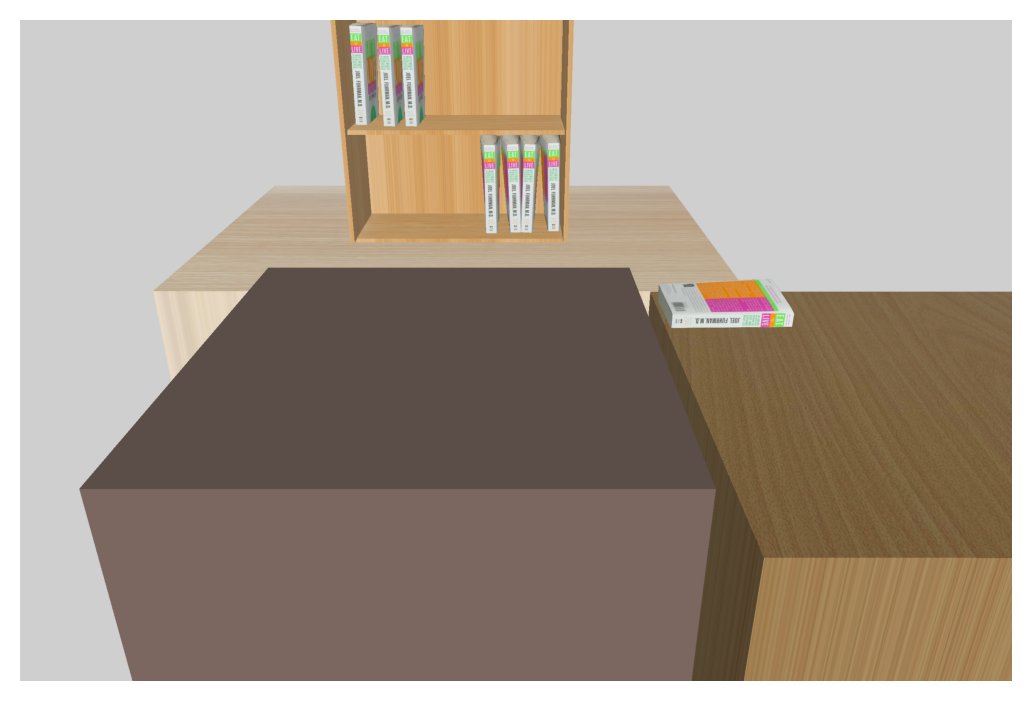

Done. Tick:[677] Time:[1.35]sec


In [8]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
# init_ur_q = np.array([0,0,0,0,np.deg2rad(90),0])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Example bounding box data (center, size)
        resolution = (10, 10, 5)  # Number of points along each axis
        points = fill_object(get_geom_region_type1(env, 'shelf_row1'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type1(env, 'shelf_row2'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type1(env, 'shelf_row3'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]

        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row1')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row2')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row3')]

        env.render(render_every=1)
        

plt.imshow(rgb_img) 
plt.axis('off')
plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

#### Store all the geometry regions

In [9]:
resolution = (10, 10, 5)  # Number of points along each axis
obj_shelf_row1_region = fill_object(get_geom_region_type1(env, 'shelf_row1'), resolution)
obj_shelf_row2_region = fill_object(get_geom_region_type1(env, 'shelf_row2'), resolution)
obj_shelf_row3_region = fill_object(get_geom_region_type1(env, 'shelf_row3'), resolution)

stacked_geom_region = np.vstack([
    obj_shelf_row1_region, obj_shelf_row2_region, obj_shelf_row3_region,
])

stacked_geom_region.shape

(1500, 3)

#### Screen geom regions considering z-axis offset

In [10]:
from utils.util import passthrough_filter, remove_duplicates_with_threshold

pcd_masked = passthrough_filter(stacked_geom_region, axis=0, interval=[0.4, 1.1])
pcd_masked = passthrough_filter(pcd_masked, axis=2, interval=[0.7, 1.3])
pcd_masked += np.array([0, 0, 0.05])
print(pcd_masked.shape)

threshold = 0.05
filtered_pcd = remove_duplicates_with_threshold(pcd_masked, threshold)
print(filtered_pcd.shape)


(1500, 3)
(105, 3)


### Get place !!!

In [11]:
env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pith", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

# filtered_pcd = np.load('./data/feasible_pcd_20230906_c48_g4_worker48_5.npy')

In [13]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'book1' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in filtered_pcd:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    while env.tick - start < end_tick:
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in filtered_pcd]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)
        if not env.is_viewer_alive(): break
        env.render(render_every=5)
    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    # print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    # print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [ 0.69 -0.22  0.81]
Pressed ESC
Quitting.
Position: [ 0.69 -0.12  0.81]
Position: [ 0.69 -0.02  0.81]
Position: [0.69 0.07 0.81]
Position: [0.69 0.17 0.81]
Position: [ 0.71 -0.17  0.81]
Position: [ 0.71 -0.07  0.81]
Position: [0.71 0.02 0.81]
Position: [0.71 0.12 0.81]
Position: [0.71 0.22 0.81]
Position: [ 0.76 -0.22  0.81]
Position: [ 0.76 -0.12  0.81]
Position: [ 0.76 -0.02  0.81]
Position: [0.76 0.07 0.81]
Position: [0.76 0.17 0.81]
Position: [ 0.79 -0.17  0.81]
Position: [ 0.79 -0.07  0.81]
Position: [0.79 0.02 0.81]
Position: [0.79 0.12 0.81]
Position: [0.79 0.22 0.81]
Position: [ 0.84 -0.22  0.81]
Position: [ 0.84 -0.12  0.81]
Position: [ 0.84 -0.02  0.81]
Position: [0.84 0.07 0.81]
Position: [0.84 0.17 0.81]
Position: [ 0.86 -0.17  0.81]
Position: [ 0.86 -0.07  0.81]
Position: [0.86 0.02 0.81]
Position: [0.86 0.12 0.81]
Position: [0.86 0.22 0.81]
Position: [ 0.91 -0.22  0.81]
Position: [ 0.91 -0.12  0.81]
Position: [ 0.91 -0.02  0.81]
Position: [0.91 0.07 0.81]
Po

### LLM screening

### Interact with GPT

In [12]:
import os
import openai
import sys
sys.path.append('../../../')
from utils.gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from utils.wiki_helper import wiki_search
from utils.util import printmd,extract_quoted_words
print ("openai version:[%s]"%(openai.__version__))

openai version:[0.27.8]


In [13]:
import openai
openai.api_key = 'your key' 
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.9,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [14]:
env.reset()

# object position lists on the table
obj_pos_list_table = {}
obj_pos_list_table['book1'] = {'position':env.get_p_body('book1'), 'size':env.model.geom(env.model.body('book1').geomadr).size}
obj_pos_list_table['book2'] = {'position':env.get_p_body('book2'), 'size':env.model.geom(env.model.body('book2').geomadr).size}
obj_pos_list_table['book3'] = {'position':env.get_p_body('book3'), 'size':env.model.geom(env.model.body('book3').geomadr).size}
obj_pos_list_table['mug_cup'] = {'position':env.get_p_body('mug_cup'), 'size':env.model.geom(env.model.body('mug_cup').geomadr).size}
obj_pos_list_table['obj_wine_01'] = {'position':env.get_p_body('obj_wine_01'), 'size':env.model.geom(env.model.body('obj_wine_01').geomadr).size}
obj_pos_list_table['obj_wine_02'] = {'position':env.get_p_body('obj_wine_02'), 'size':env.model.geom(env.model.body('obj_wine_02').geomadr).size}
obj_pos_list_table['obj_wine_03'] = {'position':env.get_p_body('obj_wine_03'), 'size':env.model.geom(env.model.body('obj_wine_03').geomadr).size}

print(obj_pos_list_table)
print(list(obj_pos_list_table.keys()))

{'book1': {'position': array([ 0.2, -0.4,  0.8]), 'size': array([0.03, 0.08, 0.11])}, 'book2': {'position': array([0.8 , 0.42, 1.2 ]), 'size': array([0.03, 0.08, 0.11])}, 'book3': {'position': array([0., 0., 0.]), 'size': array([0.03, 0.08, 0.11])}, 'mug_cup': {'position': array([-8.  ,  0.45,  1.55]), 'size': array([0.05, 0.08, 0.07])}, 'obj_wine_01': {'position': array([0.82, 0.24, 1.01]), 'size': array([0.05, 0.05, 0.08])}, 'obj_wine_02': {'position': array([0.82, 0.39, 1.01]), 'size': array([0.05, 0.05, 0.08])}, 'obj_wine_03': {'position': array([0.8 , 0.31, 1.01]), 'size': array([0.05, 0.05, 0.08])}}
['book1', 'book2', 'book3', 'mug_cup', 'obj_wine_01', 'obj_wine_02', 'obj_wine_03']


In [23]:
object_description_list = ["bookshelf_1tier", "bookshelf_2tier", "bookshelf_3tier", "table"]
target_object_name = "book1"

user_msg = \
    f"""
    Task description: 
    The task is to place the {target_object_name} on the table in best fit region.

    [Rules]
	1. The environment contains {list(obj_pos_list_table.keys())}. Do not invent new objects not listed here.
	2. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
    3. You SHOULD answer following this format: [Recommended region: Object_Name], [Not recommended region: Object_Name]. Use ONLY the list of {object_description_list} I provided.
    3. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], [Spatial_Relationship_to_the_Object], use ONLY the list of objects I provided.
	
    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
        I want to place the {target_object_name} with the same colors. Say where is the best fit placement region?
        In the 1-tier bookshelf: [book2,book4, book3,book5, book6,book7]
        In thw 2-tier bookshelf: []
        In the 3-tier bookshelf: [wine1, wine2, wine3]
    GPT-4: [Recommended region: bookshelf_2tier], [Not recommended region: bookshelf_1tier, table]
            Because, the book is located at the 2-tier bookshelf.
    If you understand, Say "I understand" and I will start the simulation.
    """

In [24]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [25]:
response_content = llm.get_answer(prompt=user_msg)

In [26]:
printmd(response_content)

[Recommended region: table], [Not recommended region: bookshelf_1tier, bookshelf_2tier, bookshelf_3tier]

Because the bookshelf regions are already occupied with other objects and the table is the only available space to place the book.

### Test on `the phyiscally plausible place`

[-0.86 -0.01  1.16]
R_body: [ 1.56 -0.04 -0.  ]
Tick: 500
Pressed ESC
Quitting.


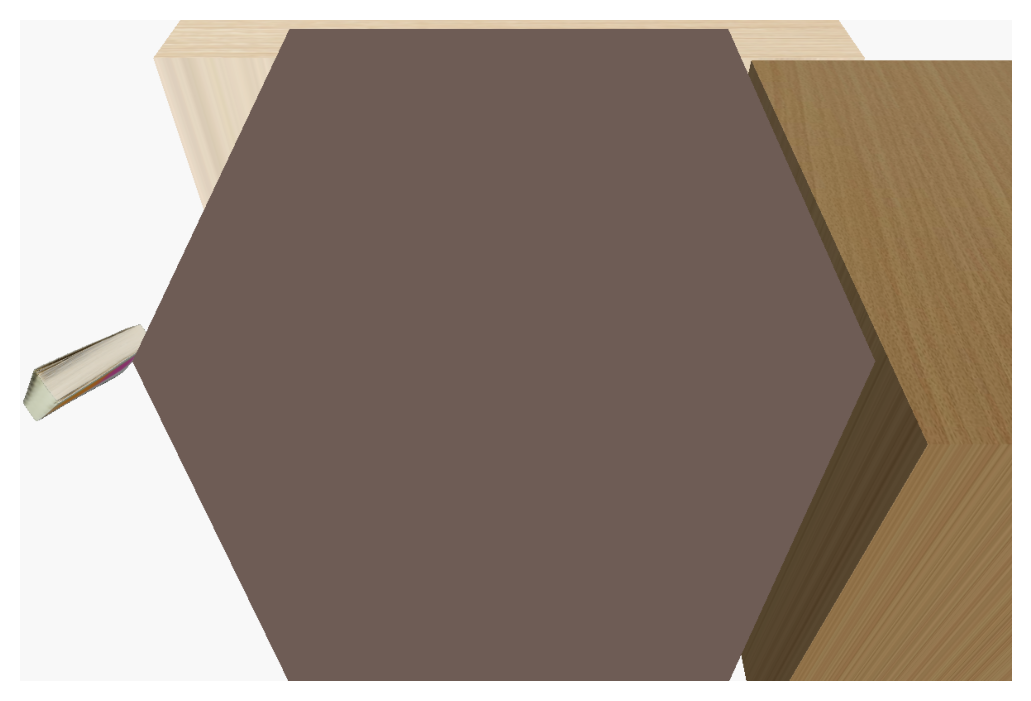

Done. Tick:[927] Time:[1.85]sec


In [13]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-90,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
print(env.get_p_body('tcp_link'))
target_obj_name = 'book1'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
qposadr = env.model.jnt_qposadr[target_cylinder_jntadr]

tick,max_sec,pcd_tick = 0,1000,0
while env.get_sim_time() <= max_sec:
    if env.tick % 500 == 0:
        env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
        env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
        print(f"R_body: {r2rpy(env.get_R_body(target_obj_name))}")
        print(f"Tick: {env.tick}")
        pcd_tick += 1
        if pcd_tick >= len(feasible_place_positions):
            # pcd_tick = len(feasible_place_positions) - 1
            pcd_tick = 0

    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)

    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # [env.plot_sphere(p=sampled_place_+np.array([0,0,0.05]), r=0.008, rgba=[0,0,1,1]) for sampled_place_ in np.array(feasible_place_positions)]

        for p in feasible_place_positions: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
        

plt.imshow(rgb_img) 
plt.axis('off')
plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

#### Solve IK: random sample from the candidate positions

In [45]:
env.init_viewer(viewer_title='IK solver',viewer_width=1200,viewer_height=800,viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

# p_target = np.array([0.8, 0.3, 1.3])
p_target = np.array([0.35, 0.0, 1.16])
R_target = rpy2r(np.array([-180,0,90])*np.pi/180.0)
q_init = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
q_init_upright = np.array([0,-np.pi/2,0,0,np.pi/2,0])
q_ik_target = env.solve_ik_repel(
    body_name='tcp_link',p_trgt=p_target,R_trgt=R_target,
    IK_P=True,IK_R=True, q_init=q_init,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1, w_weight=0.3, render_every=1.0, repulse=0, VERBOSE=False)

print(f"Initial Joint values: {q_init}")
print(f"Solved IK: {q_ik_target}")

# Close viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

### Trajectory planning phase: `Quintic` method

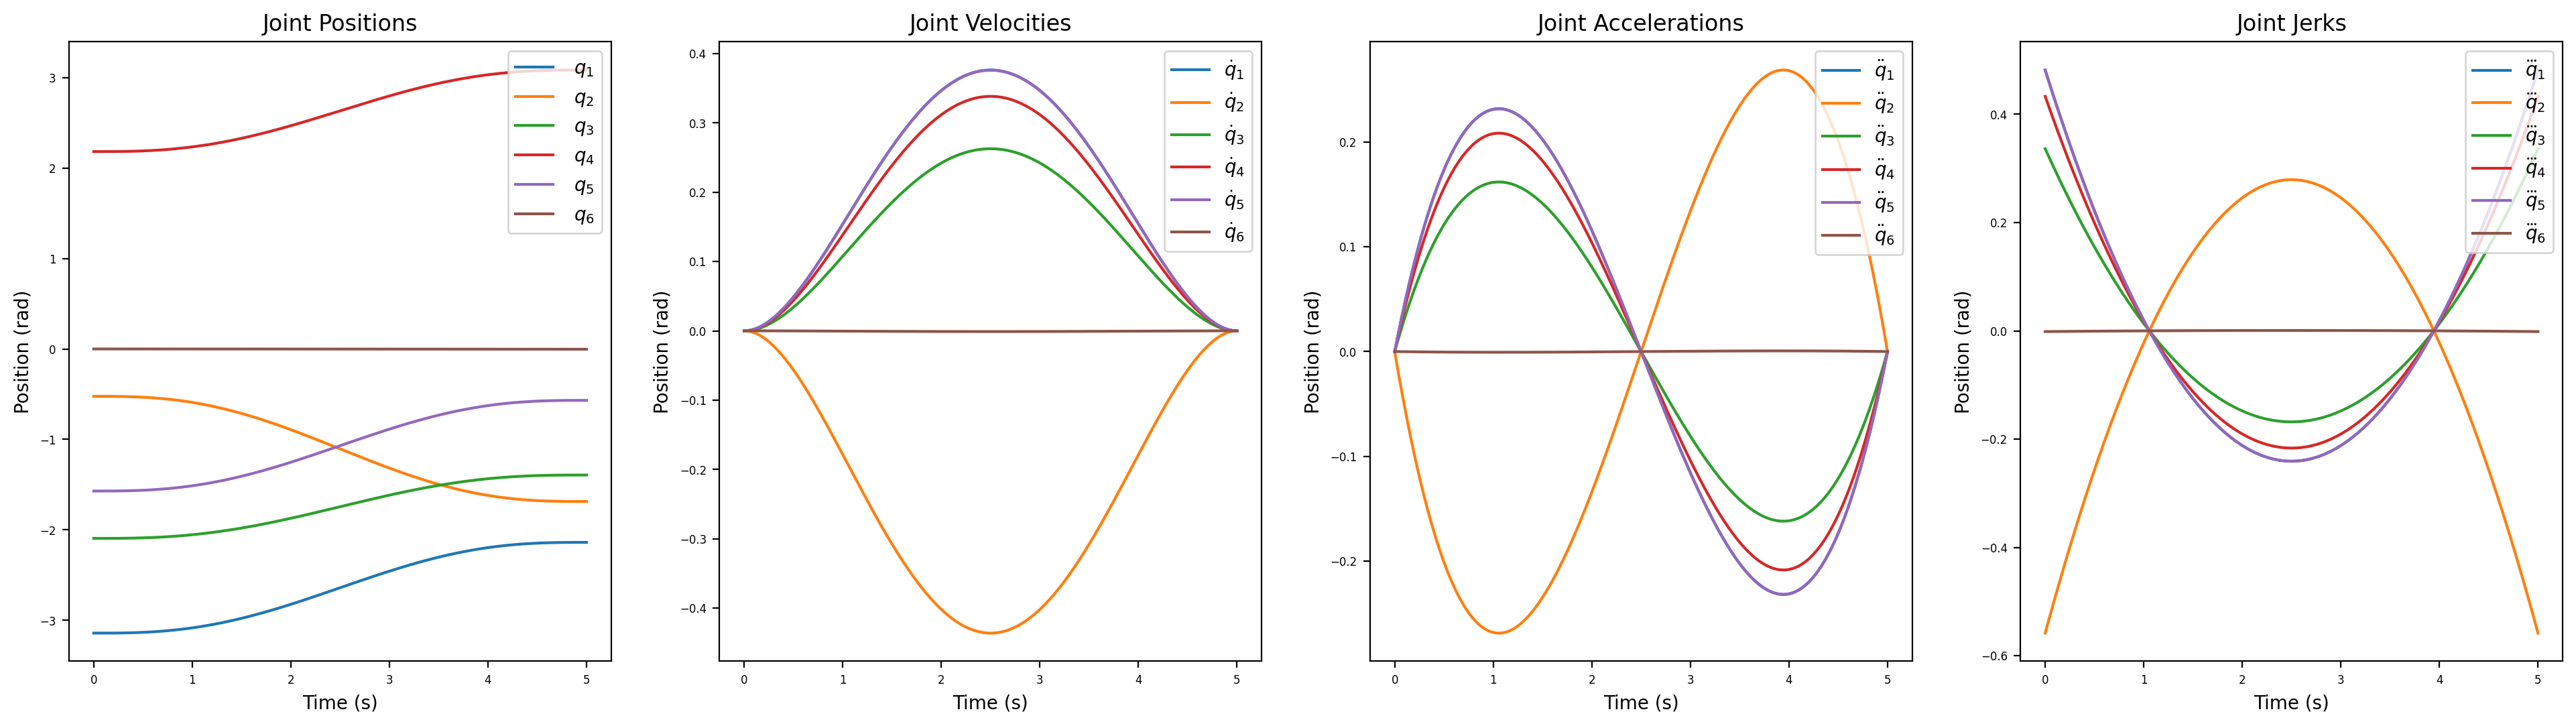

In [25]:
from utils.util import quintic_trajectory

# Define the conditions of the trajectory
q_init = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
q_init = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
start_pos = q_init
start_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
start_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_pos = q_ik_target
end_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
duration = 5.0  # Time to complete trajectory.
num_points = int(duration / env.dt)
max_velocity = 2.0
max_acceleration = 2.0

positions, velocities, accelerations, jerks = quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration)

time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 4)
for i in range(6):
    plt.plot(time_step, jerks[:, i], label=rf"$\dddot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Jerks")
plt.legend(loc='upper right')
plt.show()

In [26]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[1.0,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))
p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

env.forward(q=q_init, joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_init, ctrl_idxs=env.idxs_step)
    print(env.get_p_body('tcp_link'))
    # if tick >= len(positions):
    #     env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    # else:    
    #     env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    for p_eef in p_eef_list_np: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[0.5,0.5,0.5,0.01])
    env.render(render_every=10)

# Close viewer
env.close_viewer()
print ("Done.")

[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]
[ 0.35 -0.13  1.16]


In [27]:
env.get_p_body('base')

array([0.18, 0.  , 0.79])

In [ ]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[1.0,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))
p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

env.forward(q=q_init, joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(positions):
        env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    env.render(render_every=10)

# Close viewer
env.close_viewer()
print ("Done.")

In [ ]:
import pyvista as pv
import numpy as np

pcd = np.load('./data/stacked_geom_region.npy')
plotter = pv.Plotter()
plotter.add_points(pcd)
plotter.show()
